In [2]:
%config IPCompleter.use_jedi = False

In [1]:
import os
import json
import numpy as np
import requests
import time
import cv2
import base64
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import display, HTML
from k12libs.utils.nb_easy import RACEURL

In [3]:
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

In [4]:
API_INFERENCE = f'{RACEURL}/raceai/framework/inference'
API_INFERENCE

'http://116.85.5.40:9119/raceai/framework/inference'

In [5]:
API_POPMSG = f'{RACEURL}/raceai/private/popmsg'
API_POPMSG 

'http://116.85.5.40:9119/raceai/private/popmsg'

In [14]:
MODEL_TASK = 'zmq.garbage.resnet18.inference'
MSGKEY = 'zmq.garbage.pl.test'
IMG_ROOT = '/raceai/data/datasets/rgarbage/imgs'

# "label_names": [
#     "其他垃圾",
#     "厨余垃圾",
#     "可回收物",
#     "有害垃圾"
# ],

## 批量测试

In [15]:
cfgdata = '''{
    "task": "%s",
    "cfg": {
        "pigeon": {
            "msgkey": "%s",
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.PathListDataLoader",
            "params": {
                "data_source": [
                    "其他垃圾/其他垃圾_口罩/img_口罩_43.jpeg",
                    "厨余垃圾/厨余垃圾_果皮/西瓜皮_厨余垃圾/img_西瓜皮_11.jpeg",
                    "可回收物/可回收物_不锈钢制品/img_不锈钢制品_68.jpeg",
                    "有害垃圾/有害垃圾_电池/img_电池_44.jpeg"
                ],
                "dataset": {
                    "class_name": "raceai.data.PredictListImageDataset",
                    "params": {
                        "data_prefix": "%s",
                        "input_size": 224
                    }
                },
                "sample": {
                    "batch_size": 32,
                    "num_workers": 4,
                }
            }
        }
    }
}''' % (MODEL_TASK, MSGKEY,IMG_ROOT)

### 输入

只需要修改: `data_source` 和 `data_prefix`

```json
{
    "task": "zmq.cr.resnet18.inference",   // 任务topic, 订阅此topic的后端服务来处理此次请求
    "cfg": {
        "pigeon": {                             // 可以传输任何需要异步返回的信息
            "msgkey": "zmq.garbage.pl.test",    // 异步数据的队列key
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.PathListDataLoader",
            "params": {
                "data_source": [
                    "其他垃圾/其他垃圾_口罩/img_口罩_43.jpeg",
                    "厨余垃圾/厨余垃圾_果皮/西瓜皮_厨余垃圾/img_西瓜皮_11.jpeg",
                    "可回收物/可回收物_不锈钢制品/img_不锈钢制品_68.jpeg",
                    "有害垃圾/有害垃圾_电池/img_电池_44.jpeg"
                ],
                "dataset": {
                    "class_name": "raceai.data.PredictListImageDataset",
                    "params": {
                        "data_prefix": "/raceai/data/datasets/rgarbage/imgs",
                        "input_size": 224
                    }
                },
                "sample": {
                    "batch_size": 32,
                    "num_workers": 4,
                }
            }
        }
    }
}
```

In [16]:
reqdata = eval(cfgdata)
json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
json.loads(requests.post(url=API_INFERENCE, json=reqdata).text)
time.sleep(3)

In [17]:
json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)

[{'pigeon': {'msgkey': 'zmq.garbage.pl.test', 'user': '1', 'uuid': '100'},
  'task': 'zmq.garbage.resnet18.inference',
  'errno': 0,
  'result': [{'image_path': '/raceai/data/datasets/rgarbage/imgs/其他垃圾/其他垃圾_口罩/img_口罩_43.jpeg',
    'image_id': '-1',
    'probs': [0.4174748957157135,
     4.561334492336755e-07,
     0.5216382145881653,
     0.06088639795780182],
    'probs_sorted': {'values': [0.5216382145881653,
      0.4174748957157135,
      0.06088639795780182,
      4.561334492336755e-07],
     'indices': [2, 0, 3, 1]}},
   {'image_path': '/raceai/data/datasets/rgarbage/imgs/厨余垃圾/厨余垃圾_果皮/西瓜皮_厨余垃圾/img_西瓜皮_11.jpeg',
    'image_id': '-1',
    'probs': [0.1242741122841835,
     0.8687889575958252,
     0.0032073091715574265,
     0.003729666816070676],
    'probs_sorted': {'values': [0.8687889575958252,
      0.1242741122841835,
      0.003729666816070676,
      0.0032073091715574265],
     'indices': [1, 0, 3, 2]}},
   {'image_path': '/raceai/data/datasets/rgarbage/imgs/可回收物/可回收物_不锈钢制

### 带有image_id

In [99]:
cfgdata = '''{
    "task": "%s",
    "cfg": {
        "pigeon": {
            "msgkey": "%s",
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.PathListDataLoader",
            "params": {
                "data_source": [
                    {"image_path": "可回收物/可回收物_不锈钢制品/img_不锈钢制品_68.jpeg", "image_id": 3},
                    {"image_path": "其他垃圾/其他垃圾_口罩/img_口罩_43.jpeg", "image_id": 1},
                    {"image_path": "厨余垃圾/厨余垃圾_果皮/西瓜皮_厨余垃圾/img_西瓜皮_11.jpeg", "image_id": 2},
                    {"image_path": "有害垃圾/有害垃圾_电池/img_电池_44.jpeg", "image_id": 4}
                ],
                "dataset": {
                    "class_name": "raceai.data.PredictListImageDataset",
                    "params": {
                        "data_prefix": "%s",
                        "input_size": 224,
                        "mean": [
                            0.6535,
                            0.6132,
                            0.5643
                        ],
                        "std": [
                            0.2165,
                            0.2244,
                            0.2416
                        ]
                    }
                },
                "sample": {
                    "batch_size": 4,
                    "num_workers": 1,
                }
            }
        }
    }
}''' % (MODEL_TASK, MSGKEY,IMG_ROOT)

In [100]:
reqdata = eval(cfgdata)
json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
json.loads(requests.post(url=API_INFERENCE, json=reqdata).text)
time.sleep(1)
json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)

[{'pigeon': {'msgkey': 'zmq.garbage.pl.test', 'user': '1', 'uuid': '100'},
  'task': 'zmq.garbage.resnet18.inference',
  'errno': 0,
  'result': [{'image_path': '/raceai/data/datasets/rgarbage/imgs/可回收物/可回收物_不锈钢制品/img_不锈钢制品_68.jpeg',
    'image_id': 3,
    'probs': [0.033191993832588196,
     9.057721035787836e-05,
     0.9656627774238586,
     0.0010546991834416986],
    'probs_sorted': {'values': [0.9656627774238586,
      0.033191993832588196,
      0.0010546991834416986,
      9.057721035787836e-05],
     'indices': [2, 0, 3, 1]}},
   {'image_path': '/raceai/data/datasets/rgarbage/imgs/其他垃圾/其他垃圾_口罩/img_口罩_43.jpeg',
    'image_id': 1,
    'probs': [0.96214759349823,
     7.707124609623861e-07,
     0.037202171981334686,
     0.0006494477274827659],
    'probs_sorted': {'values': [0.96214759349823,
      0.037202171981334686,
      0.0006494477274827659,
      7.707124609623861e-07],
     'indices': [0, 2, 3, 1]}},
   {'image_path': '/raceai/data/datasets/rgarbage/imgs/厨余垃圾/厨余垃圾_果皮/西

## 单张Base64

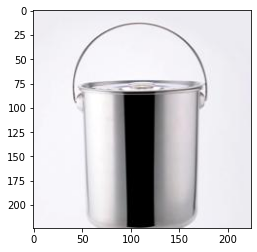

In [101]:
# test_image_path = '/hzcsk12/hzcsnote/assets/images/garbage_bread.jpeg'
# test_image_path = '/hzcsk12/hzcsnote/assets/images/garbage_thermometer.jpeg'
# test_image_path = '/hzcsk12/hzcsnote/assets/images/garbage_phone3.jpg'
test_image_path = '/raceai/data/datasets/rgarbage/imgs/可回收物/可回收物_不锈钢制品/img_不锈钢制品_68.jpeg'
test_image = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
plt.imshow(test_image);

In [102]:
def img2b64(path):
    with open(path, 'rb') as fr:
        b4data = base64.b64encode(fr.read()).decode()
    return b4data

reqdata = '''{
    "task": "%s",
    "cfg": {
        "pigeon": {
            "msgkey": "%s",
            "user": "1",
            "uuid": "100"
        },
        "data": {
            "class_name": "raceai.data.process.Base64DataLoader",
            "params": {
                "data_source": "%s",
                "dataset": {
                    "class_name": "raceai.data.PredictListImageDataset",
                    "params": {
                        "input_size": 224
                    }
                },
                "sample": {
                    "batch_size": 1,
                    "num_workers": 1,
                }
            }
        }
    }
}''' % (MODEL_TASK, MSGKEY, img2b64(test_image_path))

reqdata = eval(reqdata)
json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
json.loads(requests.post(url=API_INFERENCE, json=reqdata).text)
time.sleep(0.5)
resdata = json.loads(requests.get(url=f'{API_POPMSG}?key={MSGKEY}').text)
print(resdata)

[{'pigeon': {'msgkey': 'zmq.garbage.pl.test', 'user': '1', 'uuid': '100'}, 'task': 'zmq.garbage.resnet18.inference', 'errno': 0, 'result': [{'image_path': '/tmp/b4img_60.png', 'image_id': '-1', 'probs': [0.1440725326538086, 1.8167645976063795e-05, 0.8498671054840088, 0.006042204797267914], 'probs_sorted': {'values': [0.8498671054840088, 0.1440725326538086, 0.006042204797267914, 1.8167645976063795e-05], 'indices': [2, 0, 3, 1]}}], 'running_time': 0.231}]
